# Freckle IOT Data Engineer Challenge
*22 Oct 2017  
Farooq Qaiser*   

An open data engineering challenge based on real location data.  

1. [Admin](#Admin)
2. [RDD vs Dataframe](#RDDvsDataframe)  
3. [EDA](#EDA)
3. [IDFA statistics](#IDFA_statistics)  
4. [Geohashing](#Geohashing)
5. [Clustering](#Clustering)
6. [IDFA behavior](#Strange_IDFA_ehavior)
7. [Parquet outputs](#Parquet_outputs)

<a id='Admin'></a>
## 1. Admin  

Initialize PySpark.

In [1]:
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Freckle_challenge") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Load basic libraries (we'll load others as we need them).  

In [3]:
from pyspark.sql import functions as func

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Set display options. 

In [4]:
# show plots inline
%matplotlib inline

# show all columns
pd.set_option('display.max_columns', None)

# number of rows of output to show
show_number_of_rows = 5

Set notebook parameters.  

In [44]:
# seed value
seed = 1

# path to unzipped input data
input_path = "/home/fqaiser94/Data Engineer Challenge/location-data-sample/*.gz"

# path to output data to 
output_path = "/home/fqaiser94/DataEngChallenge/Outputs/"

Read in input data as a spark dataframe. 

In [6]:
df = spark.read.json(input_path)

<a id='RDDvsDataframe'></a>
## 2. RDD vs Dataframe

**RE: The expectation for this exercise is that you use Spark 2.x with Scala, Python, or Java. You can use the RDD or Dataframe APIs as you see fit, but please be ready to explain your choices.**  


The Dataframe APIs are able to take advantage of Spark’s Catalyst optimizer whereas operations on RDDs are imperative and have to be run in order.  

<figure>
 <img src="http://cdn.data-flair.training/blogs/wp-content/uploads/Spark-SQL-Optimization.jpg"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Spark SQL Optimization </p> 


In addition, the DataFrame APIs uses the concept of a schema which allows Spark to pass data between nodes in a more efficient way than Java serialization.  

As a result, the Dataframe APIs tend to have a speed advantage over the RDD APIs (see [here](http://www.adsquare.com/comparing-performance-of-spark-dataframes-api-to-spark-rdd/)).  

One of the main downsides however of using the Dataframe APIs is that when we're coding we have to refer to data attributes by name. As a result, it's not possible for the compiler to catch any errors (e.g. trying to access a column which does not exist) until runtime, when the actual query plan is created.  

On balance, most people recommend using the Dataframe APIs.  

There is also the newly released Dataset APIs which apparently combines the best of both worlds. Unfortunately, though this API is currently available only through scala and java.   

<a id='EDA'></a>
## 3. EDA

In this section, we perform some exploratory data analysis to get a better understanding of our data before attempting to answer the challenge questions.    

What does the dataframe schema look like?  

In [7]:
df.printSchema()

root
 |-- action: string (nullable = true)
 |-- api_key: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- beacon_major: long (nullable = true)
 |-- beacon_minor: long (nullable = true)
 |-- beacon_uuid: string (nullable = true)
 |-- city: string (nullable = true)
 |-- code: string (nullable = true)
 |-- community: string (nullable = true)
 |-- community_code: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- county: string (nullable = true)
 |-- county_code: string (nullable = true)
 |-- event_time: long (nullable = true)
 |-- geohash: string (nullable = true)
 |-- horizontal_accuracy: double (nullable = true)
 |-- idfa: string (nullable = true)
 |-- idfa_hash_alg: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- place: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- user_ip: string (nullable =

What does the actual data in each of these column look like? 

In [8]:
df.limit(show_number_of_rows).toPandas()

action  \
0                  listrequest   
1  virtual_beacon_list_request   
2                  listrequest   
3                  listrequest   
4                  listrequest   

                                             api_key  \
0  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   
1  9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb   
2  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   
3  e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0   
4  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   

                                   app_id  beacon_major  beacon_minor  \
0  smartphones.collegescoreboard.football             0             0   
1                      com.airkast.kbxxfm             0             0   
2  smartphones.collegescoreboard.football             0             0   
3                       com.checkout51.rc             0             0   
4  smartphones.collegescoreboard.football             0             0   

  beacon_uuid       city   code community community_code country_code  \
0              Littleton  80123                                    US   
1                Houston  77067                                    US   
2                 Groton  01450                                    US   
3                  Media  19063                                    US   
4                Paw Paw  49079                                    US   

      county county_code  event_time       geohash  horizontal_accuracy  \
0  Jefferson         059  1491066280  9xj32w4r1z1m                  0.0   
1     Harris         201  1491066280  9vk47vts9tx0                  9.0   
2  Middlesex         017  1491066280  drt4k62nrypf                  0.0   
3   Delaware         045  1491066280  dr475f915hgy                  0.0   
4  Van Buren         159  1491066280  dp6zvrr3u6wk                  0.0   

                                   idfa idfa_hash_alg        lat         lng  \
0  c50ab245-d660-435e-a226-8d311d2aebbf                39.628926 -105.092048   
1  8c14186b-070d-4933-a28f-a64e97afbb96                29.957772  -95.452578   
2  1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0                42.596473  -71.531639   
3  9350ce13-d0a3-422b-a047-0f534d69c217                39.916275  -75.419635   
4  a6e440f4-695b-42b2-a149-b6da243d7ea5                42.183695  -85.891952   

       place platform          state state_code         user_ip  
0  Littleton  android       Colorado         CO  184.96.241.157  
1    Houston  android          Texas         TX    45.18.76.214  
2     Groton  android  Massachusetts         MA  174.192.25.246  
3      Media      ios   Pennsylvania         PA  107.77.204.113  
4    Paw Paw  android       Michigan         MI   50.107.82.231

Looking at this output, each row/record shows where a user/IDFA was located and at what time. Looks like the information is being generated by apps on a user's phone.  

How many records do we have in total? 

In [9]:
temp = (df
        .count()
       )

print("There are %s records in the dataset." %temp)

There are 8754673 records in the dataset.


How many countries are represented in this dataset? 

In [10]:
temp = (df
        .select('country_code')
        .distinct()
        .count()
       )

print("%s countries are represented in this dataset." %temp)

69 countries are represented in this dataset.


Which countries have the most records in this dataset?  

In [11]:
(df
 .groupby('country_code')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show(show_number_of_rows)
)

+------------+-------+
|country_code|records|
+------------+-------+
|          US|6715156|
|          CA|1921178|
|          JP|  21594|
|          GU|  13946|
|          MX|  12011|
+------------+-------+
only showing top 5 rows



Not surprisingly, this dataset is particularly heavy on USA and Canada activity. Let's plot this stuff on a map to get a better sense of global activity in this dataset.  

In [12]:
temp_pd = (df
           .groupby('country_code')
           .agg(func.avg('lat').alias('lat'),
                func.avg('lng').alias('lng'), 
                func.countDistinct('idfa').alias('distinctIDFA')
               )
           .toPandas()
          )

# temp_pd.head()

In [13]:
import mplleaflet

In [14]:
temp_pd.plot(kind="scatter", 
             x="lng", 
             y="lat",
             s=np.log(temp_pd['distinctIDFA'])*10,
             c=temp_pd["distinctIDFA"],
             cmap=plt.get_cmap("jet"),
             colorbar=True, 
             alpha=0.4,
             figsize=(10,7)
            )

mplleaflet.display()

We have beacons on every (habitable) continent apparently. At the country level, its interesting to note that there doesn't appear to be any activity coming from China.  

Let's take a look at the picture at the city level and see if there's anything interesting.  

In [15]:
temp_pd = (df
           .groupby('city')
           .agg(func.avg('lat').alias('lat'),
                func.avg('lng').alias('lng'), 
                func.countDistinct('idfa').alias('distinctIDFA')
               )
           .sample(False, 0.1, seed)
           .toPandas()
          )

# temp_pd.head()

In [16]:
temp_pd.plot(kind="scatter", 
             x="lng", 
             y="lat",
             s=np.log(temp_pd['distinctIDFA'])*10,
             c=temp_pd["distinctIDFA"],
             cmap=plt.get_cmap("jet"),
             colorbar=True, 
             alpha=0.4,
             figsize=(10,7)
            )

mplleaflet.display()

What time period does the observations cover?  

In [17]:
# fix format of event_time column
df = (df
      .withColumn("event_time", func.from_unixtime("event_time"))
     )

In [18]:
(df
 .agg(func.min('event_time').alias('min_time'),
      func.max('event_time').alias('max_time'),
     )
 .toPandas()
)

min_time             max_time
0  2017-03-31 19:57:38  2017-04-01 20:01:36

We have observations from just one day.  

What values occur in the action column?  

In [19]:
(df
 .groupby('action')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .toPandas()
)

action  records
0                  listrequest  2505370
1  virtual_beacon_list_request  2325582
2                       config  1833233
3                        enter  1140386
4                         exit   773177
5          beacon_list_request   168145
6                        visit     7356
7                         near     1409
8                                    15

I can guess what *enter*, *exit*, *visit*, and *near* refer to ... the rest I don't know ... virtual_beacon_list_request, must ask more about that in interview ... anyway this information seems irrelevant to the questions I've been asked to answer so no biggie.    

Which apps appear the most often in our dataset?  

In [20]:
(df
 .groupby('app_id')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show(truncate=False)
)

+----------------------------------------+-------+
|app_id                                  |records|
+----------------------------------------+-------+
|smartphones.collegescoreboard.football  |2209154|
|ca.indigo                               |915553 |
|ca.indigo.mobile                        |650734 |
|com.c51                                 |451973 |
|com.airkast.foxfm                       |360640 |
|com.airkast.mark_levin                  |307751 |
|com.airkast.tjms                        |306903 |
|smartphones.collegescoreboard.basketball|199874 |
|com.airkast.wfunfm                      |150798 |
|com.poynt.android                       |123729 |
|com.theweathernetwork.weathereyeiphone  |103781 |
|com.airkast.rsmsfm                      |82547  |
|com.lifelikeapps.classifieds            |78858  |
|com.jacapps.wbns                        |73427  |
|com.airkast.kmjqfm                      |64750  |
|com.mcdonalds.superapp                  |63037  |
|com.multiplied.poynt          

These results make sense. We see the usual candidates, from radio station apps to sports apps and weather apps, the kinds of apps that most people would have on their on phones.  

What would be interesting to know is whether this kind of data is being generated only when a user is using an app or if the data is being generated even when the app is closed or working in the background.  

How much missing data is there in our dataset? 

In [21]:
# https://stackoverflow.com/a/33308193

def blank_as_null(x):
    
    return (func.when(func.col(x) != "", func.col(x))
            .otherwise(None))

In [22]:
# identify string fields in df
fields = df.schema.fields

str_fields = []

for i in range(0,len(fields)):
    
    if str(fields[i].dataType) in ['StringType']:
        str_fields.append(fields[i].name)
    
# columns to convert
to_convert = set(str_fields)

to_convert

{'action',
 'api_key',
 'app_id',
 'beacon_uuid',
 'city',
 'code',
 'community',
 'community_code',
 'country_code',
 'county',
 'county_code',
 'event_time',
 'geohash',
 'idfa',
 'idfa_hash_alg',
 'place',
 'platform',
 'state',
 'state_code',
 'user_ip'}

In [23]:
# convert blanks in string columns to None 
exprs = [
    blank_as_null(x).alias(x) if x in to_convert else x for x in df.columns]

df = (df.select(*exprs))

In [24]:
import missingno as msno

In [25]:
# sample 1% of rows randomly
temp = (df
        .sample(False, 0.01, seed)
        .toPandas()
       )

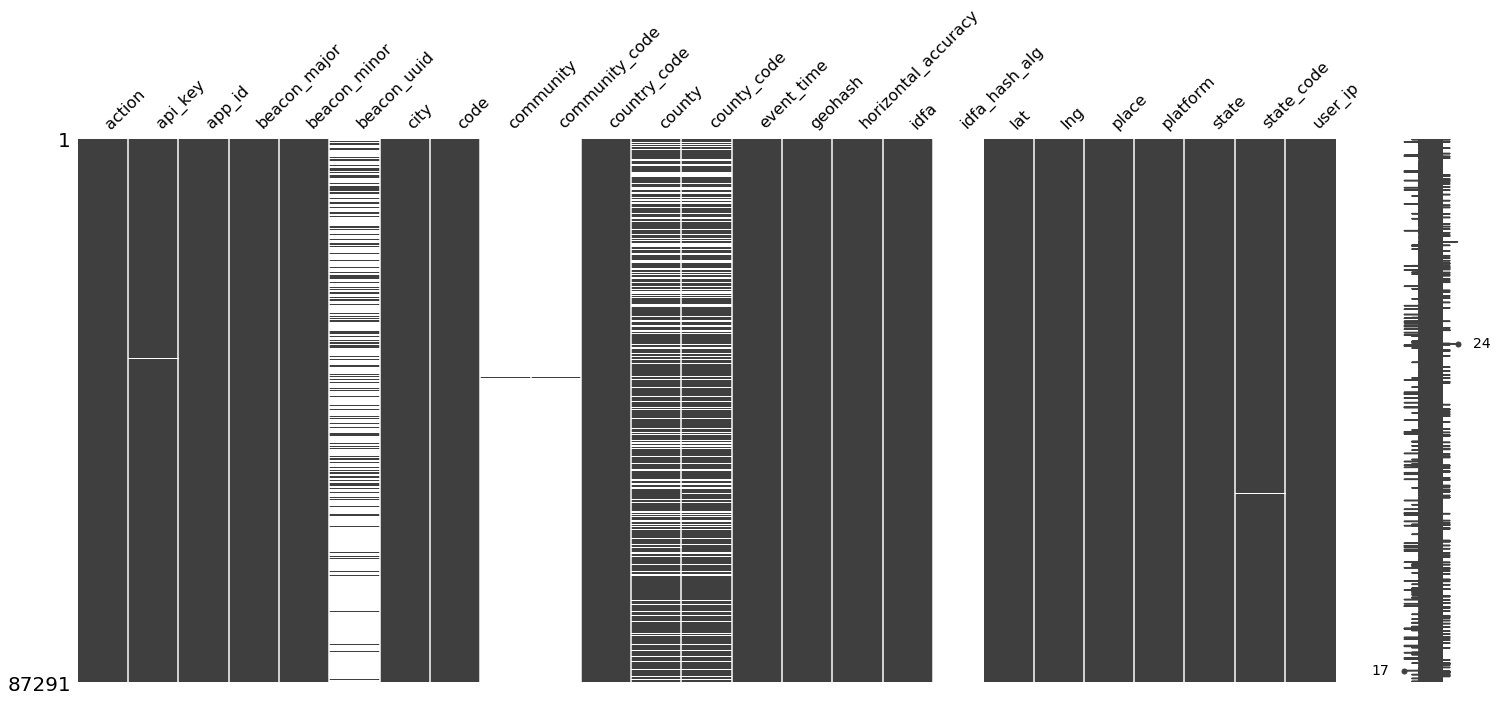

In [26]:
# visualize
msno.matrix(temp, freq=False)
plt.show()

The missing data situation doesn't appear to be too bad. There are just 3 columns with absolutely no data. Fortunately for us however, none of these columns are relevant to the challenge questions. The rest of the columns are either well populated or mostly populated.  

In [27]:
# Time series plot of number of IDFAs at timestamps

That's enough EDA, lets try answering some of the challenge questions.  

<a id='IDFA_statistics'></a>
## 4. IDFA statistics

**RE: What is the max, min, avg, std dev for the location-events per IDFA?  **

I interpreted question this as:   

1. What is the maximum **number of** location-events per IDFA? 
2. What is the minimum **number of** location-events per IDFA? 
3. What is the average **number of** location-events per IDFA? 
4. What is the standard deviation **number of** location-events per IDFA? 

I assume that each entry/row/record in this dataset is a "location-event."  

In [28]:
# calculate count of locations per idfa 
count = (df
         .groupby('idfa')
         .agg(func.count('*').alias('count'))
        )

count.show(5, truncate=False)

+------------------------------------+-----+
|idfa                                |count|
+------------------------------------+-----+
|b5b237fe-4ab2-4f00-a7c8-c6fa40f30c37|28   |
|0894896b-1b58-4b88-bd1a-a03999ff410c|58   |
|0446d012-6d80-4b26-b311-997fcbbfb02c|36   |
|564fa141-580a-4453-bf9b-29e57d29dc95|72   |
|4bf5568f-4369-4219-bc32-4e257ca389ed|31   |
+------------------------------------+-----+
only showing top 5 rows



In [29]:
# calculate min, avg, max, std dev and n for counts
stats = (count
         .agg(func.min('count').alias('min'),
              func.avg('count').alias('avg'),
              func.max('count').alias('max'),
              func.stddev('count').alias('stddev'), 
              func.sum('count').alias('n'))
            )

# stats.show(show_number_of_rows)

temp = (stats
        .toPandas()
        .transpose()
        .reset_index()
        .rename(columns={'index': 'statistic', 0: 'value'})
       )

temp.value = temp.value.round()

temp

statistic      value
0       min        1.0
1       avg       37.0
2       max    15979.0
3    stddev      119.0
4         n  8754673.0

While this is a useful summary, we tend to prefer histograms.   

In [30]:
histogram = (count
             .select('count')
             .filter("count <= 500")
             # bad solution switching to rdd
             # sadly histogram is not available for DFs
             .rdd
             .flatMap(lambda x: x)
             .histogram(1000)
            )

In [31]:
temp = (pd.DataFrame(list(histogram))
        .transpose()
        .rename(columns={0: 'bin', 1: 'count'})
       )

temp['bin'] = round(temp['bin'], 2)

temp = temp.set_index('bin')

# temp.head()

/home/fqaiser94/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


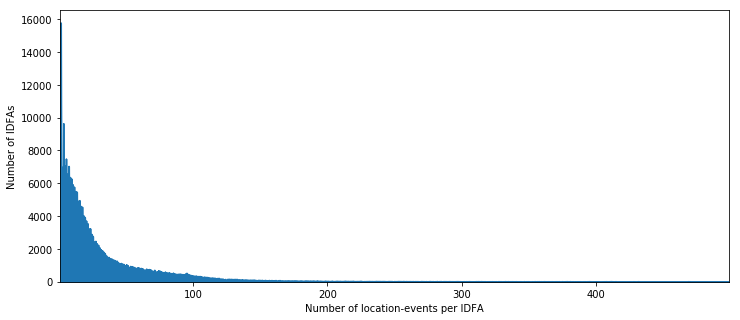

In [32]:
# from matplotlib.ticker import FormatStrFormatter

n = 50

ax = temp.plot(kind='area', y='count', figsize=(12, 5))

# ticks = ax.xaxis.get_ticklocs()
# ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
# ax.xaxis.set_ticks(ticks[::n])
# ax.xaxis.set_ticklabels(ticklabels[::n])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.legend_.remove()

plt.ylabel('Number of IDFAs')
plt.xlabel('Number of location-events per IDFA')

ax.figure.show()

Since we only have observations for a single day, it makes sense that ~99% of the IDFAs in our dataset have less than 300 locations-events associated with them.  

<a id='Geohashing'></a>
##  5. Geohashing

**RE: Produce geohashes for all coordinates in a new RDD or DataFrame.**  

The Geohash system is a simple method for encoding latitude and longitude information as well as grouping nearby points on the globe at varying resolutions. For more information, see this great [introduction](http://www.bigfastblog.com/geohash-intro).  

For convenience, we'll use the Geohash implementation found [here](https://github.com/vinsci/geohash).  

In [33]:
# if you get an error running this cmd, try installing via the following cmd
# sudo pip install python-geohash

import Geohash

In [34]:
def geohash_coords(lat,lng):
    
    """
    Function to return hash code for a coordinate of a given precision
    """
    
    hashcode = Geohash.encode(lat,lng)
    
    return hashcode

In [35]:
def geohash_decode(hashcode, coordinates=None):
    
    """
    Function to return hash code for a coordinate of a given precision
    """
    
    coords = Geohash.decode(hashcode)  
    lat = coords[0]
    lng = coords[1]
    
    if coordinates==None:
        return coords
    
    if coordinates=='latitude':
        return lat
    
    if coordinates=='longitude':
        return lng

Let's test out our functions.  

In [36]:
# encode a pair of coordinates at a high resolution 
temp = geohash_coords(lat=49,lng=-84)

# decode the geohash code
geohash_decode(temp)

(49.000000013038516, -83.99999985471368)

Excellent, this appears to be working well.  

We're provided with the latitude (lat) and longitude (lng) for each record in our dataset. The only question is what level precision do we want? Since we're trying to find clusters of people, the precision should be fairly high. I would consider people in the same building to be a cluster. In contrast, I would not consider people in the same city to be a cluster. Thus, we need to figure out what level of precision would correspond to a building.  

In [37]:
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

In [38]:
def calc_area_metres(y,x,yerror,xerror):
    
    """
    https://gist.github.com/robinkraft/c6de2f988c9d3f01af3c
    get the area in square meters of a polygon using shapely and pyproj
    
    Calculates the area defined by a geohash code  
    This takes into account the fact that the earth is spherical in shape.
    At locations near the equator, a degree has nearly the same length in X and Y. 
    Closer to the poles however this does not hold true. 
    """
    
    # bottom left corner of rectangle
    y1 = y - yerror
    x1 = x - xerror
    
    # top left corner of rectangle
    y2 = y + yerror
    x2 = x - xerror
    
    # top right corner of rectangle
    y3 = y + yerror
    x3 = x + xerror
    
    # bottom right corner of rectangle
    y4 = y - yerror
    x4 = x + xerror
    
    geom = {'type': 'Polygon',
            'coordinates': [[[y1, x1], [y2, x2],
                             [y3, x3], [y4, x4], 
                             [y1, x1]]]}

    s = shape(geom)
    
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    projected_area = transform(proj, s).area

    return projected_area

In [39]:
# https://gis.stackexchange.com/questions/231719/calculating-optimal-geohash-precision-from-bounding-box
# https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash

strg = geohash_coords(lat=49,lng=-84)

for prec in range(1,11):
    
    y,x,yerror,xerror = Geohash.decode_exactly(strg[:prec])
    xsize = 2*xerror
    ysize = 2*yerror
    area = xsize*ysize
    area_meters = calc_area_metres(y=y,x=x,yerror=yerror,xerror=xerror)
    
    print("Precision {}".format(prec))
    print("\tDecoded coordinates are ({},{})".format(y,x))
    print("\tSize is approximately {} long by {} lat".format(xsize,ysize))
    print("\tArea is {} approximately square degrees".format(area))
    print("\tArea is {} approximately square meters".format(round(area_meters,0)))

Precision 1
	Decoded coordinates are (67.5,-67.5)
	Size is approximately 45.0 long by 45.0 lat
	Area is 2025.0 approximately square degrees
	Area is nan approximately square meters
Precision 2
	Decoded coordinates are (47.8125,-84.375)
	Size is approximately 11.25 long by 5.625 lat
	Area is 63.28125 approximately square degrees
	Area is nan approximately square meters
Precision 3
	Decoded coordinates are (48.515625,-83.671875)
	Size is approximately 1.40625 long by 1.40625 lat
	Area is 1.9775390625 approximately square degrees
	Area is 223250076108.0 approximately square meters
Precision 4
	Decoded coordinates are (48.955078125,-83.84765625)
	Size is approximately 0.3515625 long by 0.17578125 lat
	Area is 0.061798095703125 approximately square degrees
	Area is 7147471764.0 approximately square meters
Precision 5
	Decoded coordinates are (49.02099609375,-84.00146484375)
	Size is approximately 0.0439453125 long by 0.0439453125 lat
	Area is 0.0019311904907226562 approximately square degre

Looking at this, I would say a precision of 9 is what we're looking for. At that level of precision, we have an area of size approximately 1 square kilometers, which in my mind is close enough to a building.  

Next, we compute geohash codes for each record in our dataset.  

In [40]:
from pyspark.sql.types import StringType, DoubleType, FloatType

In [41]:
geohash_coords_udf = func.udf(geohash_coords, StringType())

In [42]:
geohash_decode_udf = func.udf(geohash_decode, FloatType())

In [46]:
def geohash_precision(hashcode, precision=12):
    
    """
    Function to return hash code of a given precision
    """
    
    new_hashcode = hashcode[:precision]
    
    return new_hashcode

In [47]:
geohash_precision_udf = func.udf(geohash_precision, StringType())

In [48]:
df_geohash = (df
              # generate geohash code using a precision of 12 (default)
              .withColumn("geohash_12", 
                          geohash_coords_udf("lat", "lng"))
              # generate geohash code using a precision of 9
              .withColumn('geohash_9', 
                          geohash_precision_udf('geohash_12', func.lit(9)))
             )

df_geohash.limit(5).toPandas()

action  \
0                  listrequest   
1  virtual_beacon_list_request   
2                  listrequest   
3                  listrequest   
4                  listrequest   

                                             api_key  \
0  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   
1  9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb   
2  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   
3  e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0   
4  9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246   

                                   app_id  beacon_major  beacon_minor  \
0  smartphones.collegescoreboard.football             0             0   
1                      com.airkast.kbxxfm             0             0   
2  smartphones.collegescoreboard.football             0             0   
3                       com.checkout51.rc             0             0   
4  smartphones.collegescoreboard.football             0             0   

  beacon_uuid       city   code community community_code country_code  \
0        None  Littleton  80123      None           None           US   
1        None    Houston  77067      None           None           US   
2        None     Groton  01450      None           None           US   
3        None      Media  19063      None           None           US   
4        None    Paw Paw  49079      None           None           US   

      county county_code           event_time       geohash  \
0  Jefferson         059  2017-04-01 13:04:40  9xj32w4r1z1m   
1     Harris         201  2017-04-01 13:04:40  9vk47vts9tx0   
2  Middlesex         017  2017-04-01 13:04:40  drt4k62nrypf   
3   Delaware         045  2017-04-01 13:04:40  dr475f915hgy   
4  Van Buren         159  2017-04-01 13:04:40  dp6zvrr3u6wk   

   horizontal_accuracy                                  idfa idfa_hash_alg  \
0                  0.0  c50ab245-d660-435e-a226-8d311d2aebbf          None   
1                  9.0  8c14186b-070d-4933-a28f-a64e97afbb96          None   
2                  0.0  1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0          None   
3                  0.0  9350ce13-d0a3-422b-a047-0f534d69c217          None   
4                  0.0  a6e440f4-695b-42b2-a149-b6da243d7ea5          None   

         lat         lng      place platform          state state_code  \
0  39.628926 -105.092048  Littleton  android       Colorado         CO   
1  29.957772  -95.452578    Houston  android          Texas         TX   
2  42.596473  -71.531639     Groton  android  Massachusetts         MA   
3  39.916275  -75.419635      Media      ios   Pennsylvania         PA   
4  42.183695  -85.891952    Paw Paw  android       Michigan         MI   

          user_ip    geohash_12  geohash_9  
0  184.96.241.157  9xj32w4r1z1m  9xj32w4r1  
1    45.18.76.214  9vk47vts9tx0  9vk47vts9  
2  174.192.25.246  drt4k62nrypf  drt4k62nr  
3  107.77.204.113  dr475f915hgy  dr475f915  
4   50.107.82.231  dp6zvrr3u6wk  dp6zvrr3u

We're cheating a little here but you can the geohashes we've computed (geohash_2) are very similar to the ones provided with the dataset (geohash). Our geohash codes are just at a slightly lower precision (which is appropriate for our purposes in the next section).    

<a id='Clustering'></a>
## 6. Clustering

** RE: Using the geohashes, determine if there clusters of people at any point in this dataset. If so, how many people and how close are they?**  

For the purposes of this section, we say we have a cluster of people when >100 people are gathered together in a building-sized area within the same hour.  

Let's see if we can find any clusters that meets this definition using our geohash codes in this dataset.  

In [49]:
# identify countries, cities and places 
# associated with each geohash code  
geohash_descriptions = (df_geohash
                        .select("geohash_12", 
                                "country_code", 
                                "city"
                               )
                        .distinct()
                        .groupBy('geohash_12')
                        .agg(func.collect_set('country_code').alias('countries'), 
                             func.collect_set('city').alias('cities')
                            )
                       )

geohash_descriptions.show(5)

+------------+---------+--------------------+
|  geohash_12|countries|              cities|
+------------+---------+--------------------+
|6d6m9mh9p7hy|     [AR]|          [ARGUELLO]|
|6gy9zq0pckj1|     [BR]|            [Osasco]|
|6kuz1hxe519b|     [BR]|      [Assis Brasil]|
|6mc5phs2vbeg|     [BR]|[Marechal Thaumat...|
|75cj9nfxjz06|     [BR]|         [Nilópolis]|
+------------+---------+--------------------+
only showing top 5 rows



In [50]:
cluster = (df_geohash
          # we can exploit the fact that this dataset only contains 1 day
           # otherwise this code would be erroneous
           .withColumn('hour', 
                       func.hour('event_time'))
           # generate lat, lng from our geohash_2
           .withColumn('lat', 
                       geohash_decode_udf('geohash_12', func.lit('latitude')))
           .withColumn('lng', 
                       geohash_decode_udf('geohash_12', func.lit('longitude')))
           # summarise data
           .groupby('geohash_12', 'geohash_9', 'hour')
           .agg(func.countDistinct('idfa').alias('users'), 
                func.avg('lat').alias('avg_lat'), 
                func.avg('lng').alias('avg_long'), 
                func.stddev('lat').alias('stddev_lat'), 
                func.stddev('lng').alias('stddev_long'), 
               )
           # reduce amount of data
           .filter("users >= 10")
           .join(geohash_descriptions, 
                 "geohash_12")
           .orderBy('users', ascending=False)
          )

cluster.limit(5).toPandas()

geohash_12  geohash_9  hour  users       avg_lat      avg_long  \
0  s00000000000  s00000000    13    355  8.381903e-08  1.676381e-07   
1  s00000000000  s00000000    12    336  8.381903e-08  1.676381e-07   
2  s00000000000  s00000000    11    333  8.381903e-08  1.676381e-07   
3  s00000000000  s00000000    16    332  8.381903e-08  1.676381e-07   
4  s00000000000  s00000000    14    320  8.381903e-08  1.676381e-07   

   stddev_lat  stddev_long countries       cities  
0         0.0          0.0      [GU]  [Barrigada]  
1         0.0          0.0      [GU]  [Barrigada]  
2         0.0          0.0      [GU]  [Barrigada]  
3         0.0          0.0      [GU]  [Barrigada]  
4         0.0          0.0      [GU]  [Barrigada]

Getting a lot of users from the village of Barrigada in the United States territory of Guam. That doesn't make any sense ... let's try excluding geohash code s00000000 from our dataset.    

In [51]:
ignore = 's00000000000'

cluster = (df_geohash
           .filter(func.col('geohash_12')!= ignore)
           # we can exploit the fact that this dataset only contains 1 day
           # otherwise this code would be erroneous
           .withColumn('hour', 
                       func.hour('event_time'))
           # generate lat, lng from our geohash_2
           .withColumn('lat', 
                       geohash_decode_udf('geohash_12', func.lit('latitude')))
           .withColumn('lng', 
                       geohash_decode_udf('geohash_12', func.lit('longitude')))
           # summarise data
           .groupby('geohash_12', 'geohash_9', 'hour')
           .agg(func.countDistinct('idfa').alias('users'), 
                func.avg('lat').alias('avg_lat'), 
                func.avg('lng').alias('avg_long'), 
                func.stddev('lat').alias('stddev_lat'), 
                func.stddev('lng').alias('stddev_long'), 
               )
           # reduce amount of data
           .filter("users >= 10")
           .join(geohash_descriptions, 
                 "geohash_12")
           .orderBy('users', ascending=False)
          )

cluster.limit(5).toPandas()

geohash_12  geohash_9  hour  users    avg_lat    avg_long  stddev_lat  \
0  9tbntrt0eevn  9tbntrt0e    18     21  33.527634 -112.262260         0.0   
1  9tbntrt0eevn  9tbntrt0e    19     21  33.527634 -112.262260         0.0   
2  9tbntrt0eevn  9tbntrt0e    17     20  33.527634 -112.262260         0.0   
3  9tbntrt0eevn  9tbntrt0e    16     13  33.527634 -112.262260         0.0   
4  f244mdxpncbp  f244mdxpn    14     13  45.410454  -75.685898         0.0   

    stddev_long countries      cities  
0  1.214360e-14      [US]  [Glendale]  
1  3.523790e-15      [US]  [Glendale]  
2  0.000000e+00      [US]  [Glendale]  
3  1.039126e-14      [US]  [Glendale]  
4  0.000000e+00      [CA]    [Ottawa]

These results makes more sense. Sadly, the "clusters" appear to be quite small, with less than 22 users in most cases.   

How close are the people in our "clusters?"

To answer the question then, no, we do not see any clusters of people at any point in this dataset.  

One thing to be potentially wary of in this method is the possibility that neighbouring geohash codes might have completely different codes. A very basic example of this is shown below.  

<figure>
 <img src="http://commondatastorage.googleapis.com/philwhln/blog/images/geohash/geohash-gotcha.png">
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Neighbouring points with completely different geohash codes </p>
 <p style="text-align: center;"> [source](http://www.bigfastblog.com/geohash-intro) </p>

## Alternative Clustering Method

Going to try this alternative [library](https://github.com/kylebebak/py-geohash-any).  

In [63]:
from py_geohash_any import geohash as gh

Encode function.  

In [70]:
def geohash_coords(lat,lng):
    
    """
    Function to return hash code for a coordinate of a given precision
    """
    
    hashcode = gh.encode(lat,lng,12)
    
    return hashcode

In [71]:
geohash_coords_udf = func.udf(geohash_coords, StringType())

Decode function. 

In [95]:
def geohash_decode(hashcode, coordinates=None):
    
    """
    Function to return hash code for a coordinate of a given precision
    """
    
    dictionary = gh.decode(hashcode)  
    
    latitude = dictionary.get('lat')
    longitude = dictionary.get('lon')
    coords = (latitude, longitude)
    
    if coordinates==None:
        return coords
    
    if coordinates=='latitude':
        return latitude
    
    if coordinates=='longitude':
        return longitude

In [98]:
geohash_decode_udf = func.udf(geohash_decode, FloatType())

Neighbouring geohashcodes

In [175]:
def find_neighbouring(hashcode, prec=9):
    
    neighbours = gh.neighbors(hashcode, prec)
    
    neighbours_list = ''.join('{},'.format(val) for val in neighbours.values())
    
    return neighbours_list

In [176]:
find_neighbouring_udf = func.udf(find_neighbouring, StringType())

Let's test out our functions.  

In [177]:
# set up test coordinates
lat = 49
lng = -84

print('test coordinates: ({},{})'.format(lat,lng))

# encode coordinates
temp_encoded = geohash_coords(lat,lng)
print('test coordinates encoded: {}'.format(temp_encoded))

# decode the geohash code
temp_decoded = geohash_decode(temp_encoded)
print('test coordinates decoded: {}'.format(temp_decoded))

# test coordinates nearest neighbours
temp_nn = find_neighbouring(temp_encoded)
print('test coordinates nearest neighbours: {}'.format(temp_nn))


test coordinates: (49,-84)
test coordinates encoded: cDFlIDFlIDFl
test coordinates decoded: (49.0, -83.999999)
test coordinates nearest neighbours: cDFlIDFlK,cDFlIDFkX,cDFlIDFkd,cDFlIDFlD,cDFlIDFlL,cDFlIDFlJ,cDFlIDFkf,cDFlIDFlC,


Excellent these are all working.  
Let's encode our coordinates for each record and find their nearest neighbours in a precision 9 radius. 

In [182]:
df_geohash = (df
              # generate geohash code using a precision of 12 (default)
              .withColumn("geohash_12", 
                          geohash_coords_udf("lat", "lng"))
              # find nearest neighbours at a precision of 9
              .withColumn("nearest_neighbours", 
                          find_neighbouring_udf('geohash_12'))
              # explode
              #.withColumn("nearest_neighbour", 
              #            func.explode(func.split(func.col("nearest_neighbours"), ",")))
             )

df_geohash.limit(5).toPandas()

KeyboardInterrupt: 

Let's see if we can find any clusters now.  

In [ ]:
# something like this
# but this takes a long time to execute
# and using a nearest neighbour for grouping isn't right

# df_geohash = (df
#               # generate geohash code using a precision of 12 (default)
#               .withColumn("geohash_12", 
#                           geohash_coords_udf("lat", "lng"))
#               # find nearest neighbours at a precision of 9
#               .withColumn("nearest_neighbours", 
#                           find_neighbouring_udf('geohash_12'))
#               # explode
#               .withColumn("nearest_neighbour", 
#                           func.explode(func.split(func.col("nearest_neighbours"), ",")))
#               # we can exploit the fact that this dataset only contains 1 day
#               # otherwise this code would be erroneous
#               .withColumn('hour', func.hour('event_time'))
#               # generate lat, lng from our geohash_2
#               .withColumn('lat', 
#                           geohash_decode_udf('geohash_12', func.lit('latitude')))
#               .withColumn('lng', 
#                           geohash_decode_udf('geohash_12', func.lit('longitude')))
#                # summarise data
#               .groupby('nearest_neighbour', 'hour')
#               .agg(func.countDistinct('idfa').alias('users'), 
#                    func.avg('lat').alias('avg_lat'), 
#                    func.avg('lng').alias('avg_long'), 
#                    func.stddev('lat').alias('stddev_lat'), 
#                    func.stddev('lng').alias('stddev_long')
#                   )
#               # reduce amount of data
#               .filter("users >= 10")
#               .orderBy('users', ascending=False)
#              )

# df_geohash.limit(5).toPandas()

Still working on this section.  

<a id='IDFA_behavior'></a>
## 7. IDFA behaviour

**RE: Bonus: Conduct any additional analysis that might give a hint about the behaviour of the IDFAs in the data set.**

As we saw earlier, there's a lot of activity coming from the village of Barrigada in the United States territory of Guam. This seems a little suspect. 

We start by looking at some of the raw data associated with that area.  

In [53]:
strange = (df_geohash
           .filter(func.col('geohash_12')==ignore)
          )

strange.limit(5).toPandas()

action                                            api_key  \
0  config  72ac64a747d64bd3154f90183d877d2afb23b03b5096cb2b2   
1  config  72ac64a747d64bd3154f90183d877d2afb23b03b5096cb2b2   
2  config  72ac64a747d64bd3154f90183d877d2afb23b03b5096cb2b2   
3  config  72ac64a747d64bd3154f90183d877d2afb23b03b5096cb2b2   
4  config  72ac64a747d64bd3154f90183d877d2afb23b03b5096cb2b2   

             app_id  beacon_major  beacon_minor beacon_uuid       city   code  \
0  ca.indigo.mobile             0             0        None  Barrigada  96921   
1  ca.indigo.mobile             0             0        None  Barrigada  96921   
2  ca.indigo.mobile             0             0        None  Barrigada  96921   
3  ca.indigo.mobile             0             0        None  Barrigada  96921   
4  ca.indigo.mobile             0             0        None  Barrigada  96921   

  community community_code country_code county county_code  \
0      None           None           GU   Guam         010   
1      None           None           GU   Guam         010   
2      None           None           GU   Guam         010   
3      None           None           GU   Guam         010   
4      None           None           GU   Guam         010   

            event_time       geohash  horizontal_accuracy  \
0  2017-04-01 13:04:48  s00000000000                  0.0   
1  2017-04-01 13:05:12  s00000000000                  0.0   
2  2017-04-01 13:05:18  s00000000000                  0.0   
3  2017-04-01 13:05:19  s00000000000                  0.0   
4  2017-04-01 13:05:27  s00000000000                  0.0   

                                   idfa idfa_hash_alg  lat  lng      place  \
0  7657ddd3-86ae-4481-b199-1bdcdf3cb835          None  0.0  0.0  Barrigada   
1  ac4aa3f5-ffd0-4891-aa0b-74b95ddcb964          None  0.0  0.0  Barrigada   
2  38f2fa4e-087a-46d6-a3bb-1f252627037c          None  0.0  0.0  Barrigada   
3  38f2fa4e-087a-46d6-a3bb-1f252627037c          None  0.0  0.0  Barrigada   
4  bbe8c95c-c06e-48eb-88e6-7954fa63bba8          None  0.0  0.0  Barrigada   

  platform state state_code         user_ip    geohash_12  geohash_9  
0      ios    Gu         66  204.237.80.120  s00000000000  s00000000  
1      ios    Gu         66    24.76.92.156  s00000000000  s00000000  
2      ios    Gu         66    64.25.180.14  s00000000000  s00000000  
3      ios    Gu         66    64.25.180.14  s00000000000  s00000000  
4      ios    Gu         66   24.114.56.116  s00000000000  s00000000

Barrigada, Guam shouldn't have those co-ordinates. In fact, there shouldn't be anything at (0, 0) (see [here](https://www.latlong.net/c/?lat=0.000000&long=0.000000)). I assume that this is just a quirk in the geohash method. 

Let's see if there are any specific IDFAs that are generating significant activity in Barrigada, Guam.  

In [54]:
(strange
 .groupby("idfa")
 .agg(func.count("*").alias('count'))
 .orderBy('count', ascending=False)
 .limit(5)
 .toPandas()
)

idfa  count
0  00000000-0000-0000-0000-000000000000   2064
1  bb3e5486-5d75-4e15-adf3-8d7a503e9746     91
2  447c484d-67b5-47ed-b934-caaa81594933     69
3  56a3c697-75c2-4934-8463-4ecdb8916d52     26
4  b99f75e7-6dea-4ca9-8f53-f9bb78a2e173     26

It appears that there is one partifular IDFA that is causing problems. With 2064 records, this IDFA has significantly more location-events than our average IDFA (see [IDFA statistics](#IDFA_statistics)).  

Let's see the distribution of activity over time for this particular IDFA.  

In [58]:
strange_idfa = '00000000-0000-0000-0000-000000000000'

temp = (df_geohash
        .filter(func.col('idfa')==strange_idfa)
        .groupby("geohash_12", "event_time")
        .agg(func.count("*").alias("count"))
        .orderBy('event_time')
        .toPandas()
       )

temp.head()

geohash_12           event_time  count
0  9yzupckg49u3  2017-03-31 19:57:52      2
1  drt9fcvjwzz8  2017-03-31 19:58:11      1
2  dn5bgvc64cge  2017-03-31 19:58:23      1
3  9qh421e7wr0q  2017-03-31 19:58:34      1
4  c3nfk5f39bh9  2017-03-31 19:58:47      1

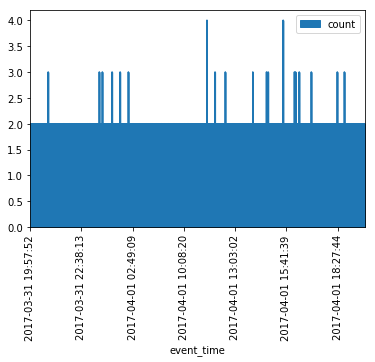

In [59]:
ax = temp.plot(kind='area', x='event_time', y='count')

plt.xticks(rotation=90)

plt.show()

Looks like that IDFA has been producing location-events activity incessantly over a period of 22 hours.  

Let's see what apps are responsible for this.  

In [60]:
(strange
 .filter(func.col('idfa')==strange_idfa)
 .groupby('app_id')
 .agg(func.count("*").alias("count"))
 .orderBy('count', ascending=False)
 .show(truncate=False)
)

+----------------------------+-----+
|app_id                      |count|
+----------------------------+-----+
|ca.indigo.mobile            |1797 |
|com.lifelikeapps.classifieds|263  |
|com.multiplied.poynt        |4    |
+----------------------------+-----+



Interesting, *ca.indigo.mobile* was one of the top apps we saw earlier during EDA as well. Is there a bug in the app that results in tons of location-events activity?  

In [61]:
(df
 .filter('app_id = "ca.indigo.mobile"')
 .groupby('app_id', 'idfa')
 .agg(func.count("*").alias("count"))
 .agg(func.avg("count").alias("average"))
 .show(truncate=False)
)

+------------------+
|average           |
+------------------+
|34.619034952386016|
+------------------+



Nope, but its good we were able to confirm that.  

<a id='Parquet_outputs'></a>
## 8. Parquet outputs

**RE: Write any findings into a local parquet format file for later use.**

In [ ]:
stats.write.parquet(output_path + "statistics.parquet")

In [ ]:
cluster.write.parquet(output_path + "clusters.parquet")

In [62]:
df.filter(func.col('idfa')==strange_idfa).write.parquet(output_path + "idfa_behaviour.parquet")

Questions to ask

- No activity in China? 
- Is the data being generated only when a user is using a given app or even when the app is closed or working in the background.